<a href="https://colab.research.google.com/github/dssg/triage/blob/master/example/colab/colab_triage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Triage Tutorial

## Problem Overview

This notebook provides a quick, interactive tutorial for [triage](http://www.datasciencepublicpolicy.org/our-work/tools-guides/triage/), a python machine learning pipeline for social good problems, using a sample of the data provided by [DonorsChoose](https://www.donorschoose.org/) to the [2014 KDD Cup](https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data). Public schools in the United States face large disparities in funding, often resulting in teachers and staff members filling these gaps by purchasing classroom supplies out of their own pockets. DonorsChoose is an online crowdfunding platform that tries to help fill this gap by allowing teachers to seek funding for projects and resources from the community (projects can include classroom basics like books and markers, larger items like lab equipment or musical instruments, specific experiences like field trips or guest speakers). Projects on DonorsChoose expire after 4 months, and if the target funding level isn't reached, the project receives no funding. Since its launch in 2000, the platform has helped fund over 2 million projects at schools across the US, but about 1/3 of the projects that are posted nevertheless fail to meet their goal and go unfunded.

For the purposes of this tutorial, we'll imagine that DonorsChoose has hired a digital content expert who will review projects and help teachers improve their postings and increase their chances of reaching their funding threshold. Because this individualized review is a labor-intensive process, the digital content expert has time to review only 10% of the projects posted to the platform on a given day. 

### The Modeling Problem

You are a data scientist working with DonorsChoose, and your task is to help this content expert focus their limited resources on projects that most need the help. As such, you want to build a model to identify projects that are least likely to be fully funded before they expire and pass them off to the digital content expert for review.

In building that model, our unit of analysis (what triage calls a **cohort**) will be new projects right at the time they're posted, while the **label** we're seeing to predict is whether or not the project reaches its funding goal in the subsequent 4 months (before it expires), making our task a binary classification problem. In order to make this prediction, we'll develop **features** that include information we know about the project when it's posted as well as historical performance of other projects posted by this teacher, school, etc.

### Outline of the Tutorial

The remainder of this tutorial will focus on how to use `triage` to solve this problem. Starting from scratch, we'll:
- **Install our tools**, including triage and a postgres server.
- **Explore the data** to get familiar with its structure.
- **Formulate the project** to make sure the models we build meet the needs of the context (and see how to configure `triage` along the way).
- **Build models**, using `triage` to run the modeling pipeline.
- **Look at the results** to ensure they make sense.
- **Select the model to deploy** using the `audition` component of `triage`.
- **Audit our models for bias** using `aequitas`.
- **Lear about next steps** and where to go from here.



## Getting Set Up

We'll need a few dependencies to run triage in a colab notebook:
- A local postgresql server (we'll use version 11)
- A simplified dataset loaded into this database (we'll use data from DonorsChoose)
- Triage and its dependencies (we'll use the current version in pypi)

In [1]:
# Install and start postgresql-11 server
!sudo apt-get -y -qq update
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" |sudo tee  /etc/apt/sources.list.d/pgdg.list
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-11 postgresql-client-11
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

# Setup a database with name `donors_choose` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS donors_choose;'

!sudo -u postgres psql -U postgres -c 'CREATE DATABASE donors_choose;'

# Environment variables for connecting to the database
%env DEMO_DATABASE_NAME=donors_choose
%env DEMO_DATABASE_HOST=localhost
%env DEMO_DATABASE_PORT=5432
%env DEMO_DATABASE_USER=postgres
%env DEMO_DATABASE_PASS=postgres

OK
deb http://apt.postgresql.org/pub/repos/apt/ bionic-pgdg main
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 15.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package cron.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128.1ubuntu1.2_amd64.deb ...
Unpacking cron (3.0pl1-128.1ubuntu1.2) ...
Selecting previously unselected package logrotate.
Preparing to unpack .../01-logrotate_3.11.0-0.1ubuntu1_amd64.deb ...
Unpacking logrotate (3.11.0-0.1ubuntu1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../02-netbase_5.4_all

In [2]:
# Download sampled DonorsChoose data and load it into our postgres server
!curl -s -OL https://dsapp-public-data-migrated.s3.us-west-2.amazonaws.com/donors_sampled_20210920_v3.dmp
!PGPASSWORD=$DEMO_DATABASE_PASS pg_restore -h $DEMO_DATABASE_HOST -p $DEMO_DATABASE_PORT -d $DEMO_DATABASE_NAME -U $DEMO_DATABASE_USER -O -j 8 donors_sampled_20210920_v3.dmp

In [3]:
# Install triage and its dependencies
!pip install triage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 253 kB 4.9 MB/s 
     |████████████████████████████████| 46 kB 4.4 MB/s 
     |████████████████████████████████| 11.3 MB 40.2 MB/s 
     |████████████████████████████████| 80 kB 9.3 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 210 kB 50.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 3.0 MB 53.4 MB/s 
     |████████████████████████████████| 132 kB 74.8 MB/s 
     |████████████████████████████████| 2.2 MB 48.5 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 96 kB 5.5 MB/s 
     |████████████████████████████████| 16.8 MB 51.0 MB/s 
     |████████████████████████████████| 1.3 MB 48.9 MB/s 
     |████████████████████████████████| 41.6 MB 1.5 MB/s 
     |████████████████████████████████| 83

🛑  &nbsp;&nbsp;**NOTE: Before continuing, your colab runtime may need to be restarted for the installed packages to take effect. If a "Restart Runtime" button appeared at the bottom of the output above, be sure to click it before moving on to the next section!**

## A Quick Look at the DonorsChoose Data

Before getting into triage, let's just take a quick look at the data we'll be using here. To get started, we'll need to connect to the database we just created...

In [1]:
from sqlalchemy.engine.url import URL
from triage.util.db import create_engine
import pandas as pd

db_url = URL(
            'postgres',
            host='localhost',
            username='postgres',
            database='donors_choose',
            password='postgres',
            port=5432,
        )

db_engine = create_engine(db_url)

2022-12-23 04:03:54 -    INFO NumExpr defaulting to 2 threads.


The DonorsChoose dataset contains four main tables we'll need here:
- **Projects** contains information about each project as well as some details about the teacher posting it and their school and district
- **Essays** contains the detailed descriptions that the teacher post describing their project and needs
- **Resources** contains detailed information about the specific number, type, and cost of resources being asked for in the project
- **Donations** contains information about the donations received by each project on a transactional level, as well as some details about the donor

Let's take a look at the projects:

In [2]:
pd.read_sql('SELECT COUNT(*) FROM data.projects', db_engine)

,count
0,16480


In [3]:
pd.read_sql('SELECT * FROM data.projects LIMIT 5', db_engine)

,schoolid,projectid_str,teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,poverty_level,grade_level,fulfillment_labor_materials,total_asking_price,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,entity_id
0,29a2da790e38b6c8a1c70aced6b9c765,30c034618e67d00c641f9b5b7775c0f4,0903da60e148adc6280d55f5d94791a5,192013001182,41.428391,-91.049135,Muscatine,IA,52761,None,...,high poverty,Grades 6-8,35.0,511.32,601.55,100,False,False,2012-08-06,234148
1,06ef48acbdf9b013d4bc4bfc8d328cc1,94199c544d9d2926c1820e5c6cde1eb6,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,...,high poverty,Grades 3-5,35.0,167.43,192.45,40,False,False,2010-07-10,453579
2,06ef48acbdf9b013d4bc4bfc8d328cc1,61f42f174afef1ed2419ab948a647137,fb340c7ac3b22a5984c6a82602e4a510,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,...,high poverty,Grades 3-5,35.0,167.43,196.98,45,False,False,2011-06-09,353855
3,06ef48acbdf9b013d4bc4bfc8d328cc1,c966f5226f42aaaf6b115d7dbaefdea3,e0b5a72f41a376b28db9c2e838a24de5,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,...,high poverty,Grades 3-5,35.0,162.14,190.75,25,False,False,2011-06-13,353178
4,06ef48acbdf9b013d4bc4bfc8d328cc1,69e9c24111daa1e6ba64c6d5538e4df1,32e86c49396707f71fdc0398ab2b844b,450111000143,32.233070,-80.855905,Bluffton,SC,29910,rural,...,high poverty,Grades 3-5,35.0,381.27,448.55,25,False,False,2012-07-15,239363


Note that the `projectid_str` column can be used to link out to the other tables. For instance, let's look at what we can find out about project `30c034618e67d00c641f9b5b7775c0f4`:

In [4]:
pd.read_sql("SELECT * FROM data.essays WHERE projectid_str='30c034618e67d00c641f9b5b7775c0f4'", db_engine)

,projectid_str,teacher_acctid,title,short_description,need_statement,essay,entity_id,date_posted
0,30c034618e67d00c641f9b5b7775c0f4,0903da60e148adc6280d55f5d94791a5,Illuminate Your Future,Can you imagine what the future will bring wit...,My students need LED bulbs and electronic comp...,Can you imagine what the future will bring wit...,234148,2012-08-06


In [5]:
pd.read_sql("""
  SELECT project_resource_type,
        COUNT(*) AS num_distinct_resources, 
        SUM(item_quantity) AS num_total_resources,
        AVG(item_unit_price) AS avg_price,
        SUM(item_unit_price * item_quantity) AS total_cost
  FROM data.resources 
  WHERE projectid_str='30c034618e67d00c641f9b5b7775c0f4'
  GROUP BY 1;
  """, db_engine)

,project_resource_type,num_distinct_resources,num_total_resources,avg_price,total_cost
0,Supplies,7,113.0,13.004286,400.19


In [6]:
pd.read_sql("""
  SELECT 
    COUNT(*) AS num_donations,
    SUM(donation_to_project) AS total_donation,
    SUM(CASE WHEN is_teacher_acct THEN 1 ELSE 0 END) AS num_teacher_donation
  FROM data.donations 
  WHERE projectid_str='30c034618e67d00c641f9b5b7775c0f4'
  ;
  """, db_engine)

,num_donations,total_donation,num_teacher_donation
0,1,511.32,0


## Formulating the project

Now that we're familiar with the available data, let's turn to the prediction problem at hand. Because reviewing and offering suggestions to posted projects will be time and resource-intensive, we might assume that DonorsChoose can only help a fraction of all projects that get posted, let's suppose 10%. Then, we might formulate our problem along the lines of:

**Each day, for all the projects posted on that day, can we identify the 10% of projects with the highest risk of not being fully funded within 4 months to prioritize for review by digital content experts.**

With this formulation in mind, we can define a cohort and label for our analysis. `triage` will allow us to define these directly as a SQL query, so let's start there...

### Defining the Cohort and Label

Because most models to inform important decisions will need to generalize into the future, `triage` focuses on respecting the temporal nature of the data (discussed in more detail below). The `cohort` is the set of relevant entities for model training/prediction at a given point in time, which `triage` referrs to as an `as_of_date`.

🚧 &nbsp;&nbsp;NOTE: In `triage`, an `as_of_date` is taken to be midnight at the **beginning** of that date.

Here, the cohort is relatively straightforward: we simply want to identify all of the projects that were posted, right on the day of posting. Although we were looking at the identifier `projectid_str` above, `triage` looks for a column called `entity_id` to uniquely identify entities to its models. We've already added this column to this dataset, so we'll use that below.

🚧 &nbsp;&nbsp;NOTE: `triage` expects entities in the data to be identified by an **integer column** called `entity_id`.

For modeling, we also need to consider the outcome we care about. Returning to our formulation, we described trying to identify projects which will not be fully funded within the four months they are active on the platform.

As with the cohort, notice that labels are calculated relative to a given point in time (the `as_of_date` described above) and over a specific time horizon (here, 4 months from posting). In triage, this time horizon is referred to as a `label_timespan` and is also available as a parameter to your label definition.

With those details in mind, let's look at an example of how we might define the cohort and label from our data for this project:

In [7]:
example_as_of_date = '2012-08-07'
example_label_timespan = '4month'

pd.read_sql("""
    WITH cohort_query AS (
      SELECT distinct(entity_id)
      FROM data.projects
      WHERE date_posted = '{as_of_date}'::date - interval '1day'
    )
    , cohort_donations AS (
      SELECT 
        c.entity_id, 
        COALESCE(SUM(d.donation_to_project), 0) AS total_donation
      FROM cohort_query c
      LEFT JOIN data.donations d 
        ON c.entity_id = d.entity_id
        AND d.donation_timestamp 
          BETWEEN '{as_of_date}'::date - interval '1day'
          AND '{as_of_date}'::date + interval '{label_timespan}'
      GROUP BY 1
    )
    SELECT c.entity_id,
    CASE 
      WHEN COALESCE(d.total_donation, 0) >= p.total_asking_price THEN 0
      ELSE 1
    END AS outcome  
    FROM cohort_query c
    JOIN data.projects p USING(entity_id)
    LEFT JOIN cohort_donations d using(entity_id)
  ;
  """.format(as_of_date=example_as_of_date, label_timespan=example_label_timespan), db_engine)

,entity_id,outcome
0,234035,1
1,234148,0
2,234234,0


Here, we start by defining our cohort as described above, then find all the donations to those projects within the label timespan (e.g., the following 4 months after posting), and finally compare that to the total price of the project to create a binary classification label for whether or not the project was fully funded.

Notice here that because we will intervene on projects at risk for **NOT** being fully funded, we define this as our class 1 label while those that do reach their funding goal are given class 0.

In `triage` we'll be able to use `{as_of_date}` as a placeholder for time just as we're doing here. Also note that because the `as_of_date` is taken to be midnight, we're looking at the projects posted the previous day (hence subtracting the 1 day interval in the query).

For `triage`, we use a yaml format for configuration (described further below) and we'll be able to provide this query directly:
```
label_config:
  query: |
    WITH cohort_query AS (
      SELECT distinct(entity_id)
      FROM data.projects
      WHERE date_posted = '{as_of_date}'::date - interval '1day'
    )
    , cohort_donations AS (
      SELECT 
        c.entity_id, 
        COALESCE(SUM(d.donation_to_project), 0) AS total_donation
      FROM cohort_query c
      LEFT JOIN data.donations d 
        ON c.entity_id = d.entity_id
        AND d.donation_timestamp 
          BETWEEN '{as_of_date}'::date - interval '1day'
          AND '{as_of_date}'::date + interval '{label_timespan}'
      GROUP BY 1
    )
    SELECT c.entity_id,
    CASE 
      WHEN COALESCE(d.total_donation, 0) >= p.total_asking_price THEN 0
      ELSE 1
    END AS outcome  
    FROM cohort_query c
    JOIN data.projects p USING(entity_id)
    LEFT JOIN cohort_donations d using(entity_id)

  name: 'fully_funded'
```

For more details these two pieces of the modeling pipeline, see the [cohort and label deep dive in the triage docs](https://dssg.github.io/triage/experiments/cohort-labels/). 

### Dealing with Time

As noted above, `triage` is designed for problems where the desire to generalize to future data and therefore is careful to respect the temporal nature of the problem. This is particularly salient in two places: defining the validation strategy for model evaluation and ensuring that features only make use of information available at the time of analysis/prediction.

For validation, the idea is generally simple: models should be trained on historical data and validated on future data. As such, `triage` constructs validation splits that reflect this process by using a certain point in time as the cut-off between training and validation and then moving this cut-off back through the data to generate multiple splits. The implementation is a bit more complicated and relies on several parameters, the details of which we won't go deep into here, but you can find a much deeper discussion in the [longer "dirty duck" tutorial](https://dssg.github.io/triage/dirtyduck/triage_intro/) as well as in the [experiment config docs](https://dssg.github.io/triage/experiments/experiment-config/).

![temporal figure](https://dssg.github.io/triage/experiments/temporal_config_graph.png)

In short, these parameters are (illustrated across three training/validation splits in the figure above):
- feature start/end times: what range of history is feature information available for?
- label start/end times: what range of history is outcome (label) data available for?
- model update frequency: what is the interval between refreshes of the model?
- test durations: over what time period will the model be in use for making predictions?
- max training history: how much historical data should be used for model training (that is, for rows/examples)?
- training/test as_of_date frequencies: within a training or validation (test) set, how frequently should cohorts be sampled?
- training/test label timespans: over what time horizon are labels (outcomes) collected?

As with the cohorts and labels, these parameters are specified to `triage` via its yaml configuration file. Here's what this will look like for our setting:
```
temporal_config:

    # first date our feature data is good
    feature_start_time: '2000-01-01'
    feature_end_time: '2013-06-01'

    # first date our label data is good
    # donorschoose: as far back as we have good donation data
    label_start_time: '2011-09-02'
    label_end_time: '2013-06-01'

    model_update_frequency: '4month'

    # length of time defining a test set
    test_durations: ['3month']
    # defines how far back a training set reaches
    max_training_histories: ['1y']

    # we sample every day, since new projects are posted
    # every day
    training_as_of_date_frequencies: ['1day']
    test_as_of_date_frequencies: ['1day']
    
    # when posted project timeout
    label_timespans: ['3month']
```

### Model Evaluation Metrics

The temporal configuration described above will create several training and validation splits that can be used to estimate the generalization performance of your models and select a model specification to use going forward. In order to do so, of course, you need to choose an appropriate metric (or metrics) by which to evaluate your models. `triage` can use any of the metrics specified by `sklearn` and in general you'll want to focus on those that best reflect the goals, constraints, and deployment scenario of your project. For instance, in our example project, DonorsChoose can help only 10% of the projects posted to the site, so a metric like precision in the top 10% would reflect how efficiently these limited resources are being allocated to projects that would not be fully funded without additional support.

Although we might want to focus on `precision@10%` as our primary metric, often it can be helpful to look at both precision and recall at a range of thresholds (both percentiles and absolute numbers) both for the purposes of debugging and understanding how sensitive your results are to the available resources, describing a "menu" of policy choices.

The `scoring` section of the yaml configuration file allows you specify separate evaluation metrics for both the training and validation set results, indicating both the type of metric (e.g., `precision`, `recall`, etc) and, where needed, the thresholds at which to calculate them. Here's what that looks like for our example project:

```
scoring:
    testing_metric_groups:
        -
          metrics: [precision@, recall@]
          thresholds:
              percentiles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 
                  10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                  20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
                  30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
                  40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                  50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                  60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                  70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                  80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                  90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                  100]
              top_n: [25, 50, 100]

    training_metric_groups:
        -
          metrics: [precision@, recall@]
          thresholds:
              percentiles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 
                  10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                  20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
                  30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
                  40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                  50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                  60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                  70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                  80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                  90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                  100]
              top_n: [25, 50, 100]
```

### Defining Features

Feature generation is typically the most important aspect of how well your machine learning models will work, so `triage` provides considerable flexibility for feature definition. However, this also means that this section of the configuration file can be particularly complicated and may require some experimentation to get familiar with. A few resources may be helpful for a deeper look at how features work in `triage`:
- [Feature Definition in the Quickstart Guide](https://dssg.github.io/triage/triage_project_workflow/#define-some-additional-features)
- [Feature Generation in the triage Documentation](https://dssg.github.io/triage/experiments/experiment-config/#feature-generation)
- [Features in the Example Configuration File](https://github.com/dssg/triage/blob/master/example/config/experiment.yaml#L102)

Features in `triage` are defined in blocks, grouping together features drawn from the same data source and allowing several related features to be constructed in a very compact format. Each of these blocks is a list item under the `feature_aggregations` section of your yaml configuration file and contains the following information:
- A `prefix` that is used to identify the group of features.
- A `from_obj` that specifies the underlying information used to construct the features in this group. This can be either a table or a query in itself (in the later case, be sure to give it an alias) and must contain both an `entity_id` column as well as a date column indicating when the information was known, identified to the feature config as the `knowledge_date_column`.
- Information about how missing values should be imputed (see the documentation for details and available options here).
- Definitions of the feature quantities/columns themselves, specified either as `aggregates` or `categoricals`, including the `metrics` for aggregations over time (e.g., `sum`, `max`, `avg`, etc).
- Time ranges over which to calculate feature information, called `intervals` (e.g., last 6 months, last 5 years, etc.)
- A level of aggregation for feature information (`groups`) -- this will almost always be just `entity_id`.

🚧 &nbsp;&nbsp;NOTE: All features in `triage` are temporal aggregates. Just as `triage` is designed to carefully account for time in temporal cross-validation, it also does so in feature construction focusing on what information was known at training or validation time. Even features you might generally consider "static" need to be associated with a knowledge date for these purposes as well as an aggregation metric. This is also true for categoricals, which are first one-hot encoded from each instance then aggregated over the given time interval with the specified metric. For instance, if a patient has had several hospital stays with different primary diagnosis codes at each stay, a categorical feature using a `sum` aggregation would yield a count of how many stays had a given diagnosis while a `max` aggregation would provide an indicator of whether a given diagnosis was ever present. 

For aggregations of numeric features, the resulting feature names will have the format: 
`{prefix}_entity_id_{interval}_{quantity}_{metric}`

For categoricals, the feature names will include each categorical value after one-hot encoding:
`{prefix}_entity_id_{interval}_{quantity}_{value}_{metric}`

🚧 &nbsp;&nbsp;WARNING: Because `triage`'s features are stored in a `postgres` database, this naming convention can sometimes run afoul of the database's 63 character limit for column names, leading to truncation. When this happens, you might encounter errors indicating a given feature column appears to be missing. This can be common with categoricals with particularly long values, so recoding can be useful in those cases (as can choosing shorter prefix names).

For illustrative purposes here, we'll start with a single feature group including one categorical and continuous aggregate feature: the primary resource type for the project and the amount being asked for. Because these are both specified once at project posting time, we simply aggegate them over all time (that is, using `all` for our `interval`). Here's how we specify this in our feature configuration:

```
feature_aggregations:
  -
    prefix: 'project_features'
    from_obj: 'data.projects'
    knowledge_date_column: 'date_posted'

    aggregates_imputation:
      all:
        type: 'zero'

    categoricals_imputation:
      all:
        type: 'null_category'          

    categoricals:
      -
        column: 'resource_type'
        metrics:
          - 'max' 
        choice_query: 'select distinct resource_type from data.projects'
    
    aggregates:
      -
        quantity: 'total_asking_price'
        metrics:
          - 'sum'
      
    # Since our time-aggregate features are precomputed, feature interval is 
    # irrelvant. We keep 'all' as a default.
    intervals: ['all'] 
    groups: ['entity_id']
```

### Model and Hyperparameter Grid

You specify the types of models you want to explore, along with their hyperparameters, in the `grid_config` section of your yaml configuration file. Because there's generally no way to know a priori what model specification will work best for a given problem, `triage` makes it easy to run and explore an extensive grid by providing lists of values for each hyperparameter and training models for the full cross-product of these values.

Currently, `triage` can work with any classifiction method with an `sklearn`-style interface. In addition to machine learning algorithms found in standard packages, `triage` includes a couple of built-in methods you might find useful:
- `ScaledLogisticRegression` wraps the `sklearn`  logistic regression with a min-max scaler to ensure that the input features are on the same scale for regularization. It accepts the same hyperparameters as the underlying `sklearn` method.
- `BaselineRankMultiFeature` is a simple baseline method that ranks examples by one or more features, replicating a comonsense approach that could be taken without making use of machine learning. This method takes a single hyperparameter, `rules`, specified as a list of dictionaries with the keys `feature` and `low_value_high_score` to specify the directin of the ranking. Examples are sorted first by the first feature in this list, then the next, and so on.
- `SimpleThresholder` is another basic baseline method, allowing you to specify a heuristic, rule-based approach to classifying examples. It uses two hyperparameters: a list of `rules` (e.g., `feature_1 > 3`) and a `logical_operator` (e.g., `and` or `or`) to specify how the rules are combined.

To specify a model type in your grid config, you use the model's class path as a key and each hyperparameter as a key another level down. For example:
```
'module.submodule.ClassName':
    param_1: [1,3,5,10,20]
    param_2: [100, 500, 1000]
```

For our purposes here, we'll start with a very small grid that can run quickly in a colab notebook. Here's how that will look:
```
grid_config:
    'sklearn.ensemble.RandomForestClassifier':
        n_estimators: [150]
        max_depth: [50]
        min_samples_split: [25]
    
    'sklearn.tree.DecisionTreeClassifier':
        max_depth: [3]
        max_features: [null]
        min_samples_split: [25]
      
    'triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression':
        C: [0.1]
        penalty: ['l1']
    
    'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature':
        rules:
            - [{feature: 'project_features_entity_id_all_total_asking_price_sum', low_value_high_score: False}]
```

### Auditing Models for Bias

The final section of the configuration file specifies how you want to evaluate your models for bias and fairness using the [aequitas](http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/) toolkit. In order to do so, you need to tell `triage` what attributes are relavent for bias audits, a table or SQL query to specify these attributes (the `from_obj`), and the reference group to calculate disparities relative to (the value for this group will serve as the denominator for disparity calculations. Like the evaluation metrics described above, you'll also need to specify the set of thresholds against which you want to calculate fairness metrics. Note that `aequitas` will calculate the full range of confusion matrix-derived disparity metrics for all of your models, allowing you to explore how your models perform under different conceptualizations of fairness.

To illustrate the use of a bias audit in our example project, we'll look at the `teacher_prefix` attribute as a proxy for the sex of the teacher, using `Mr.` as a reference group. Note that the `from_obj_table` will be joined using an `entity_id` and `as_of_date`, so you must specify a `knowledge_date_column` in the config, as some attributes (or your knowledge of them) might change over time. `aequitas` will use the most recent value of the attribute it finds for a given entity prior to the specified `as_of_date`. Here's how we turn that into a section in our configuration yaml:

```
bias_audit_config:
    from_obj_table: 'data.projects'
    attribute_columns:
        - 'teacher_prefix'
    knowledge_date_column: 'date_posted'
    entity_id_column: 'entity_id'
    ref_groups_method: 'predefined'
    ref_groups:
        'teacher_prefix': 'Mr.'
    thresholds:
        percentiles: [5, 10, 15, 20, 25, 50, 100]
        top_n: [25, 50, 100]
```

## Running Triage

Now that we've walked through the various aspects of configuring triage, we're ready to run our model grid! In order to do so, we need three pieces:
- Our configuration file, pulling together the elements described above into a single yaml file we'll call `experiment_config.yaml` (in `triage`, an "experiment" is a run with a set of parameters and model types).
- Credentials for connecting to your database, stored in a configuration file called `database.yaml` (alternatively, you can specify them through environment variables)
- Code to run your `triage` experiment. This can be done via either a command line tool or python interface, the latter of which provides more flexibility so we'll focus on that approach here with a short python script called `run.py`.

The following three sections provides the contents of each of these three files for our DonorsChoose project. In a real project, of course, these would be stored as separate files on your system, but here we include them inline. The `run.py` sets up logging, connects to the database, loads your configuration file, and creates and runs a `MultiCoreExperiment` object from `triage`.

### experiment_config.yaml

In [9]:
config_yaml = """
config_version: 'v8'

model_comment: 'triage demo'

random_seed: 1995

temporal_config:

    # first date our feature data is good
    feature_start_time: '2000-01-01'
    feature_end_time: '2013-06-01'

    # first date our label data is good
    # donorschoose: as far back as we have good donation data
    label_start_time: '2011-09-02'
    label_end_time: '2013-06-01'

    model_update_frequency: '4month'

    # length of time defining a test set
    test_durations: ['3month']
    # defines how far back a training set reaches
    max_training_histories: ['1y']

    # we sample every day, since new projects are posted
    # every day
    training_as_of_date_frequencies: ['1day']
    test_as_of_date_frequencies: ['1day']
    
    # when posted project timeout
    label_timespans: ['3month']


label_config:
  query: |
    WITH cohort_query AS (
      SELECT distinct(entity_id)
      FROM data.projects
      WHERE date_posted = '{as_of_date}'::date - interval '1day'
    )
    , cohort_donations AS (
      SELECT 
        c.entity_id, 
        COALESCE(SUM(d.donation_to_project), 0) AS total_donation
      FROM cohort_query c
      LEFT JOIN data.donations d 
        ON c.entity_id = d.entity_id
        AND d.donation_timestamp 
          BETWEEN '{as_of_date}'::date - interval '1day'
          AND '{as_of_date}'::date + interval '{label_timespan}'
      GROUP BY 1
    )
    SELECT c.entity_id,
    CASE 
      WHEN COALESCE(d.total_donation, 0) >= p.total_asking_price THEN 0
      ELSE 1
    END AS outcome  
    FROM cohort_query c
    JOIN data.projects p USING(entity_id)
    LEFT JOIN cohort_donations d using(entity_id)

  name: 'fully_funded'


feature_aggregations:
  -
    prefix: 'project_features'
    from_obj: 'data.projects'
    knowledge_date_column: 'date_posted'

    aggregates_imputation:
      all:
        type: 'zero'

    categoricals_imputation:
      all:
        type: 'null_category'          

    categoricals:
      -
        column: 'resource_type'
        metrics:
          - 'max' 
        choice_query: 'select distinct resource_type from data.projects'
    
    aggregates:
      -
        quantity: 'total_asking_price'
        metrics:
          - 'sum'
      
    # Since our time-aggregate features are precomputed, feature interval is 
    # irrelvant. We keep 'all' as a default.
    intervals: ['all']

grid_config:
    'sklearn.ensemble.RandomForestClassifier':
        n_estimators: [150]
        max_depth: [50]
        min_samples_split: [25]
    
    'sklearn.tree.DecisionTreeClassifier':
        max_depth: [3]
        max_features: [null]
        min_samples_split: [25]
      
    'triage.component.catwalk.estimators.classifiers.ScaledLogisticRegression':
        C: [0.1]
        penalty: ['l1']
    
    'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature':
        rules:
            - [{feature: 'project_features_entity_id_all_total_asking_price_sum', low_value_high_score: False}]


scoring:
    testing_metric_groups:
        -
          metrics: [precision@, recall@]
          thresholds:
              percentiles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 
                  10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                  20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
                  30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
                  40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                  50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                  60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                  70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                  80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                  90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                  100]
              top_n: [25, 50, 100]

    training_metric_groups:
        -
          metrics: [precision@, recall@]
          thresholds:
              percentiles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 
                  10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                  20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
                  30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 
                  40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
                  50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
                  60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
                  70, 71, 72, 73, 74, 75, 76, 77, 78, 79,
                  80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
                  90, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                  100]
              top_n: [25, 50, 100]
          
bias_audit_config:
    from_obj_table: 'data.projects'
    attribute_columns:
        - 'teacher_prefix'
    knowledge_date_column: 'date_posted'
    entity_id_column: 'entity_id'
    ref_groups_method: 'predefined'
    ref_groups:
        'teacher_prefix': 'Mr.'
    thresholds:
        percentiles: [5, 10, 15, 20, 25, 50, 100]
        top_n: [25, 50, 100]

individual_importance:
    methods: [] # empty list means don't calculate individual importances
    n_ranks: 1 
"""

### database.yaml

In [10]:
database_yaml = """
host: localhost
user: postgres
db: donors_choose
pass: postgres
port: 5432
role: postgres
"""

### run.py

In [11]:
import yaml

from sqlalchemy.engine.url import URL
from triage.util.db import create_engine
from triage.experiments import MultiCoreExperiment
import logging

import os

from sqlalchemy.event import listens_for
from sqlalchemy.pool import Pool

def run_triage():

  # andrew_id = os.getenv('USER')
  # user_path = os.path.join('/data/users/', andrew_id)
  user_path = '/content'

  # add logging to a file (it will also go to stdout via triage logging config)
  log_filename = os.path.join(user_path, 'triage.log')
  logger = logging.getLogger('')
  hdlr = logging.FileHandler(log_filename)
  hdlr.setLevel(15)   # verbose level
  hdlr.setFormatter(logging.Formatter('%(name)-30s  %(asctime)s %(levelname)10s %(process)6d  %(filename)-24s  %(lineno)4d: %(message)s', '%d/%m/%Y %I:%M:%S %p'))
  logger.addHandler(hdlr)

  # creating database engine
  # dbfile = os.path.join(user_path, 'database.yaml')

  # with open(dbfile, 'r') as dbf:
  #     dbconfig = yaml.safe_load(dbf)

  dbconfig = yaml.safe_load(database_yaml)
  print(dbconfig['role'])

  # assume group role to ensure shared permissions
  @listens_for(Pool, "connect")
  def assume_role(dbapi_con, connection_record):
      logging.debug(f"setting role {dbconfig['role']};")
      dbapi_con.cursor().execute(f"set role {dbconfig['role']};")
      # logging.debug(f"setting role postres;")
      # dbapi_con.cursor().execute(f"set role postgres;")

  db_url = URL(
              'postgres',
              host=dbconfig['host'],
              username=dbconfig['user'],
              database=dbconfig['db'],
              password=dbconfig['pass'],
              port=dbconfig['port'],
          )

  db_engine = create_engine(db_url)

  triage_output_path = os.path.join(user_path, 'triage_output')
  os.makedirs(triage_output_path, exist_ok=True)

  # loading config file
  # with open('%s_triage_config.yaml' % andrew_id, 'r') as fin:
  #     config = yaml.safe_load(fin)

  config = yaml.safe_load(config_yaml)

  # creating experiment object
  experiment = MultiCoreExperiment(
      config = config,
      db_engine = db_engine,
      project_path = triage_output_path,
      n_processes=2,
      n_bigtrain_processes=1,
      n_db_processes=2,
      replace=True,
      save_predictions=True
      )

  # experiment.validate()
  experiment.run()

### Let's run triage!

With these three files in place, we can simply run our model grid by calling `run_triage()`. Doing so will train and validate the four model specifications described above across three temporal validation splits. The run will output a log of its progress and store results into the postgres database.

In [12]:
run_triage()

postgres
2022-12-23 04:06:23 - VERBOSE Matrices and trained models will be saved in /content/triage_output
2022-12-23 04:06:23 -  NOTICE Replace flag is set to true. Matrices, models, evaluations and predictions (if they exist) will be replaced
2022-12-23 04:06:23 -    INFO No results_schema_versions table exists, which means that this installation is fresh. Upgrading db.
2022-12-23 04:06:23 -    INFO Context impl PostgresqlImpl.
2022-12-23 04:06:23 -    INFO Will assume transactional DDL.
2022-12-23 04:06:23 -    INFO Running upgrade  -> 8b3f167d0418, empty message
2022-12-23 04:06:24 -    INFO Running upgrade 8b3f167d0418 -> 0d44655e35fd, empty message
2022-12-23 04:06:24 -    INFO Running upgrade 0d44655e35fd -> 264245ddfce2, empty message
2022-12-23 04:06:24 -    INFO Running upgrade 264245ddfce2 -> 72ac5cbdca05, Change importance to float
2022-12-23 04:06:24 -    INFO Running upgrade 72ac5cbdca05 -> 7d57d1cf3429, empty message
2022-12-23 04:06:24 -    INFO Running upgrade 7d57d1cf

## Checking the results

Running `triage` will generate two types of outputs: objects stored to disk and results stored in the database.

Two types of objects will be stored to disk in the `project_path` specified in creating the experiment object:
- The matrices used for model training and validation, stored as CSV files and associated metadata in yaml format.
- The trained model objects themselves, stored as `joblib` pickles, which can be loaded and applied to new data.

In the database, `triage` will store results and metadata in several tables. Below is a very brief tour of the most important of these tables.

In the **triage_metadata** schema, you'll find information about your run and the models that were created:
- `triage_metadata.triage_runs`: metadata about every time `triage` is run, identified by a `run_id`
- `triage_metadata.experiments`: configuration information for an experiment, identified by an `experiment_hash`. Note that a config file can be run multiple times, so a specific experiment might be associated with multiple `triage_runs` records. The `experiment_hash` can be linked to the `run_hash` in the `triage_runs` table where `run_type='experiment'`
- `triage_metadata.model_groups`: in `triage` a `model_group` represents a full specification of a model type, set of hyperparameters, set of features, and training set parameters
- `triage_metadata.models`: a `model` represents the application of a `model_group` to a given training set, yielding a set of trained parameters (such as the coefficients of a logistic regression, the splits of a decision tree, etc). The models are identified by both a `model_id` and `model_hash` and can be linked to their `model_group` via the `model_group_id`
- `triage_metadata.experiment_models`: the association between models and experiments (linking an `experiment_hash` to a `model_hash`)

In the **test_results** schema, you'll find information about the validation performance of the models:
- `test_results.evaluations`: performance of each model on the metrics specified in the `scoring` section of your configuration file
- `test_results.predictions`: individual entity-level predicted scores from each model
- `test_results.prediction_metadata`: metadata associated with the predictions
- `test_results.aequitas`: performance of each model on the fairness metrics using the parameters specified in your `bias_audit_config`

In the **train_results** schema, you'll find model performance on the training set, as well as feature importances:
- `train_results.evaluations`: similar to `test_results.evaluations` but for the training set (often may be overfit, but can be useful for debugging)
- `train_results.predictions`: similar to `test_results.predictions` but for the training set
- `train_results.prediction_metadata`: metadata associated with the predictions
- `train_results.feature_importances`: overall feature importances from model training, usining the built-in method for the classifier (if one exists)

Finally, a few intermediate tables can be particularly useful for debugging:
- Tables containing your `cohort` and `label` will be generated in the `public` schema and identified by an associated hash that can be found in your logs.
- The `features` schema contains two types of useful tables: tables containing calculated features for each feature group and "matrix" tables that provide the mapping from each training/validation matrix to `(entity_id, as_of_date)` pairs. Note, however, that these tables may be overwritten if a new run is performed with different feature logic, cohort, or underlying data and should not be assumed to be persistant across runs.

Let's take a quick look at some of these outputs to confirm that our models ran as expected. First, we'll need a database connection...

In [13]:
import yaml
from sqlalchemy.engine.url import URL
from triage.util.db import create_engine
import pandas as pd

dbconfig = yaml.safe_load(database_yaml)
db_url = URL(
            'postgres',
            host=dbconfig['host'],
            username=dbconfig['user'],
            database=dbconfig['db'],
            password=dbconfig['pass'],
            port=dbconfig['port'],
        )

db_engine = create_engine(db_url)

`triage_metadata.model_groups` should contain four records (for each model type/hyperparameter combination specified in our grid), while `triage_metadata.models` should have twelve (each model group trained on the three validation splits):

In [14]:
pd.read_sql('SELECT * FROM triage_metadata.model_groups;', db_engine)

,model_group_id,model_type,hyperparameters,feature_list,model_config
0,1,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 150, 'min_sa...",[project_features_entity_id_all_resource_type_...,"{'state': 'active', 'label_name': 'fully_funde..."
1,2,sklearn.tree.DecisionTreeClassifier,"{'max_depth': 3, 'max_features': None, 'min_sa...",[project_features_entity_id_all_resource_type_...,"{'state': 'active', 'label_name': 'fully_funde..."
2,3,triage.component.catwalk.estimators.classifier...,"{'C': 0.1, 'penalty': 'l1'}",[project_features_entity_id_all_resource_type_...,"{'state': 'active', 'label_name': 'fully_funde..."
3,4,triage.component.catwalk.baselines.rankers.Bas...,{'rules': [{'feature': 'project_features_entit...,[project_features_entity_id_all_resource_type_...,"{'state': 'active', 'label_name': 'fully_funde..."


In [15]:
pd.read_sql('SELECT * FROM triage_metadata.models;', db_engine)

,model_id,model_group_id,model_hash,run_time,batch_run_time,model_type,hyperparameters,model_comment,batch_comment,config,train_end_time,test,train_matrix_uuid,training_label_timespan,model_size,random_seed,built_in_triage_run
0,1,2,6da4c22152666c3269bd469f73f370b6,2022-12-23 04:07:08.897160,2022-12-23 04:07:08.570142,sklearn.tree.DecisionTreeClassifier,"{'max_depth': 3, 'max_features': None, 'min_sa...",triage demo,None,None,2012-04-01,False,57daeffb23ac85eb628f4fd66d843e98,90 days,0.046875,908907174,1
1,2,3,4b7bf3e25bb4fae996c97416e2af5c01,2022-12-23 04:07:08.910111,2022-12-23 04:07:08.570142,triage.component.catwalk.estimators.classifier...,"{'C': 0.1, 'penalty': 'l1'}",triage demo,None,None,2012-04-01,False,57daeffb23ac85eb628f4fd66d843e98,90 days,0.046875,1656233507,1
2,3,4,9a11734d9bcfd9c1812e4f0db1cdb900,2022-12-23 04:07:37.703928,2022-12-23 04:07:08.570142,triage.component.catwalk.baselines.rankers.Bas...,{'rules': [{'feature': 'project_features_entit...,triage demo,None,None,2012-04-01,False,57daeffb23ac85eb628f4fd66d843e98,90 days,0.046875,1259133573,1
3,4,2,a344624ed0187bf12d385bfc9a07bd46,2022-12-23 04:07:38.737398,2022-12-23 04:07:08.610994,sklearn.tree.DecisionTreeClassifier,"{'max_depth': 3, 'max_features': None, 'min_sa...",triage demo,None,None,2012-08-01,False,7be1c9af421575360abd144c37e932d9,90 days,0.046875,1106414652,1
4,5,3,71d2c03597f606a21e00845419f9f79a,2022-12-23 04:07:48.417060,2022-12-23 04:07:08.610994,triage.component.catwalk.estimators.classifier...,"{'C': 0.1, 'penalty': 'l1'}",triage demo,None,None,2012-08-01,False,7be1c9af421575360abd144c37e932d9,90 days,0.046875,897217774,1
5,6,4,e82690d9330c0fa2353cea09f1cddda6,2022-12-23 04:08:18.115892,2022-12-23 04:07:08.610994,triage.component.catwalk.baselines.rankers.Bas...,{'rules': [{'feature': 'project_features_entit...,triage demo,None,None,2012-08-01,False,7be1c9af421575360abd144c37e932d9,90 days,0.046875,1431439151,1
6,7,2,d745e6e4ec9a91ad096f7e079fd3bd58,2022-12-23 04:08:26.162836,2022-12-23 04:07:08.648648,sklearn.tree.DecisionTreeClassifier,"{'max_depth': 3, 'max_features': None, 'min_sa...",triage demo,None,None,2012-12-01,False,b45d17062154c8ddb8ec28a2c8d17788,90 days,0.046875,1463730397,1
7,8,3,aa9cda0d59c535c12f695792e62ce224,2022-12-23 04:08:26.162893,2022-12-23 04:07:08.648648,triage.component.catwalk.estimators.classifier...,"{'C': 0.1, 'penalty': 'l1'}",triage demo,None,None,2012-12-01,False,b45d17062154c8ddb8ec28a2c8d17788,90 days,0.046875,1879462244,1
8,9,4,695d62ad8324ac78e001844047a0e084,2022-12-23 04:09:03.035092,2022-12-23 04:07:08.648648,triage.component.catwalk.baselines.rankers.Bas...,{'rules': [{'feature': 'project_features_entit...,triage demo,None,None,2012-12-01,False,b45d17062154c8ddb8ec28a2c8d17788,90 days,0.046875,827031307,1
9,10,1,0e809a87d99b4390e43eecaf2193c897,2022-12-23 04:09:08.355586,2022-12-23 04:07:08.570142,sklearn.ensemble.RandomForestClassifier,"{'max_depth': 50, 'n_estimators': 150, 'min_sa...",triage demo,None,None,2012-04-01,False,57daeffb23ac85eb628f4fd66d843e98,90 days,0.046875,1443952767,1


You can find the predictions from each model for each project in `test_results.predictions`. Let's take a quick look...

In [16]:
pd.read_sql('SELECT * FROM test_results.predictions LIMIT 5;', db_engine)

,model_id,entity_id,as_of_date,score,label_value,rank_abs_no_ties,rank_abs_with_ties,rank_pct_no_ties,rank_pct_with_ties,matrix_uuid,test_label_timespan
0,3,254981,2012-04-12,1.00000,0,1,1,0.00258,0.00259,9916387c3af41f79c711eca5b49e2e93,90 days
1,3,249195,2012-05-12,0.99740,1,2,2,0.00515,0.00518,9916387c3af41f79c711eca5b49e2e93,90 days
2,3,255422,2012-04-09,0.99481,0,3,3,0.00773,0.00777,9916387c3af41f79c711eca5b49e2e93,90 days
3,3,253874,2012-04-18,0.99221,0,4,4,0.01031,0.01036,9916387c3af41f79c711eca5b49e2e93,90 days
4,3,250376,2012-05-09,0.98961,1,5,5,0.01289,0.01295,9916387c3af41f79c711eca5b49e2e93,90 days


In [17]:
pd.read_sql("""
  SELECT 
    model_id, 
    COUNT(*) AS num_preds, 
    COUNT(DISTINCT entity_id) AS distinct_entities, 
    AVG(label_value) AS non_funded_rate
  FROM test_results.predictions 
  GROUP BY 1
  ORDER BY 1;
  """, db_engine)

,model_id,num_preds,distinct_entities,non_funded_rate
0,1,388,388,0.394330
1,2,388,388,0.394330
2,3,388,388,0.394330
3,4,1124,1124,0.378114
4,5,1124,1124,0.378114
5,6,1124,1124,0.378114
6,7,635,635,0.420472
7,8,635,635,0.420472
8,9,635,635,0.420472
9,10,388,388,0.394330


Note that the `label_value` column here is the actual label (e.g., if the project actually failed to be fully funded in four months).

If we want to see how the model performed on your evaluation metrics, you can find these results calculated in `test_results.evaluations`. Let's look at how our models did in term of precision at the top 10% since that reflects our deployment setting:

In [18]:
pd.read_sql("""
  SELECT *
  FROM test_results.evaluations 
  WHERE metric='precision@' AND parameter='10_pct'
  ORDER BY model_id;
  """, db_engine)

,model_id,evaluation_start_time,evaluation_end_time,as_of_date_frequency,metric,parameter,num_labeled_examples,num_labeled_above_threshold,num_positive_labels,sort_seed,matrix_uuid,subset_hash,best_value,worst_value,stochastic_value,num_sort_trials,standard_deviation
0,1,2012-04-01,2012-06-30,1 days,precision@,10_pct,388,38,153,None,9916387c3af41f79c711eca5b49e2e93,,1.000000,0.026316,0.496491,30,0.052963
1,2,2012-04-01,2012-06-30,1 days,precision@,10_pct,388,38,153,None,9916387c3af41f79c711eca5b49e2e93,,1.000000,0.000000,0.435965,30,0.070370
2,3,2012-04-01,2012-06-30,1 days,precision@,10_pct,388,38,153,None,9916387c3af41f79c711eca5b49e2e93,,0.342105,0.342105,0.342105,0,0.000000
3,4,2012-08-01,2012-10-31,1 days,precision@,10_pct,1124,112,425,None,a81c0dc805971d5bc9104d35826100d9,,1.000000,0.000000,0.448512,30,0.036301
4,5,2012-08-01,2012-10-31,1 days,precision@,10_pct,1124,112,425,None,a81c0dc805971d5bc9104d35826100d9,,1.000000,0.000000,0.447024,30,0.040472
5,6,2012-08-01,2012-10-31,1 days,precision@,10_pct,1124,112,425,None,a81c0dc805971d5bc9104d35826100d9,,0.383929,0.383929,0.383929,0,0.000000
6,7,2012-12-01,2013-02-28,1 days,precision@,10_pct,635,63,267,None,65fe592cbac55bff7f2c08b4a1933cb7,,1.000000,0.000000,0.501587,30,0.060922
7,8,2012-12-01,2013-02-28,1 days,precision@,10_pct,635,63,267,None,65fe592cbac55bff7f2c08b4a1933cb7,,1.000000,0.000000,0.470370,30,0.059462
8,9,2012-12-01,2013-02-28,1 days,precision@,10_pct,635,63,267,None,65fe592cbac55bff7f2c08b4a1933cb7,,0.603175,0.603175,0.603175,0,0.000000
9,10,2012-04-01,2012-06-30,1 days,precision@,10_pct,388,38,153,None,9916387c3af41f79c711eca5b49e2e93,,0.473684,0.473684,0.473684,0,0.000000


Finally, if you need to work with the training/validation matrices generated by triage or the model objects themselves, you can find them in your project path (here, `triage_output`). Let's take a quick look...

In [19]:
!ls triage_output/

matrices  trained_models


In [20]:
!ls -la triage_output/matrices/


total 128
drwxr-xr-x 2 root root  4096 Dec 23 04:07 .
drwxr-xr-x 4 root root  4096 Dec 23 04:07 ..
-rw-r--r-- 1 root root  9055 Dec 23 04:07 57daeffb23ac85eb628f4fd66d843e98.csv.gz
-rw-r--r-- 1 root root  4115 Dec 23 04:07 57daeffb23ac85eb628f4fd66d843e98.yaml
-rw-r--r-- 1 root root  6201 Dec 23 04:07 65fe592cbac55bff7f2c08b4a1933cb7.csv.gz
-rw-r--r-- 1 root root  3335 Dec 23 04:07 65fe592cbac55bff7f2c08b4a1933cb7.yaml
-rw-r--r-- 1 root root 17532 Dec 23 04:07 7be1c9af421575360abd144c37e932d9.csv.gz
-rw-r--r-- 1 root root  7019 Dec 23 04:07 7be1c9af421575360abd144c37e932d9.yaml
-rw-r--r-- 1 root root  3990 Dec 23 04:07 9916387c3af41f79c711eca5b49e2e93.csv.gz
-rw-r--r-- 1 root root  3359 Dec 23 04:07 9916387c3af41f79c711eca5b49e2e93.yaml
-rw-r--r-- 1 root root 10686 Dec 23 04:07 a81c0dc805971d5bc9104d35826100d9.csv.gz
-rw-r--r-- 1 root root  3383 Dec 23 04:07 a81c0dc805971d5bc9104d35826100d9.yaml
-rw-r--r-- 1 root root 23598 Dec 23 04:07 b45d17062154c8ddb8ec28a2c8d17788.csv.gz
-rw-r--r-

In [21]:
# clean up the database connection
db_engine.dispose()

## Model Selection

`triage` includes a component called `audition` that can help you visualize your model results over time and narrow down your best-performing models. Here we'll provide a quick introduction, but you can find more depth in the [audition tutorial](https://github.com/dssg/triage/blob/master/src/triage/component/audition/Audition_Tutorial.ipynb) as well as the [audition documentation](https://dssg.github.io/triage/audition/audition_intro/) and [model selection concepts overview](https://dssg.github.io/triage/audition/model_selection/). In general, `audition` is best run using a notebook to iteratively explore and narrow down your models.

### Audition Parameters

To run `audition`, you'll need to specify a few parameters:

`metric` and `parameter` together specify the evaluation metric of interest for your project. Note that these need to be calculated as part of the scoring section in your `triage` config and should match the values in the columns of the same name in `test_results.evaluations`

The `run_hash` is an identifier for the run with your complete model grid that you want to evaluate -- the easiest way to find this is from the `triage_metadata.triage_runs` table. This will likely be the `run_hash` associated with the most recent record in that table, but you should be able to figure out which run you want to use from there.

In [22]:
from triage.component.audition import Auditioner
from triage.component.audition.pre_audition import PreAudition
from triage.component.audition.rules_maker import SimpleRuleMaker, RandomGroupRuleMaker, create_selection_grid

from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

import yaml
from sqlalchemy.engine.url import URL
from triage.util.db import create_engine

import logging
logging.basicConfig(level=logging.WARNING)

import pandas as pd
pd.set_option('precision', 4)

In [28]:
metric = 'precision@'
parameter = '10_pct'
run_hash = 'f825e69ab968bb314b283e55bf8f6640'

In [24]:
dbconfig = yaml.safe_load(database_yaml)
db_url = URL(
            'postgres',
            host=dbconfig['host'],
            username=dbconfig['user'],
            database=dbconfig['db'],
            password=dbconfig['pass'],
            port=dbconfig['port'],
        )

conn = create_engine(db_url)

In [25]:
# table where audition results will be stored
best_dist_table = 'audition_best_dist'

### Pre-Audition: Models and Temporal Splits

Because you may have run several experiments as you iterate, explore, and debug, `audition` needs to know which set of model groups and temporal validation splits to focus on for model selection. While you can specify these directly, `triage` also provides some `pre-audition` tools to help define these.

For example, `get_model_groups_from_experiment()` and `get_train_end_times()` (note that this will return the `train_end_times` associated with the set of model groups returned by one of the `get_model_groups` methods, so those should be run first). Note that the `baseline_model_types` parameter in the constructor is optional and can be used to identify model groups as baselines rather than candidates for model selection.

In [29]:
pre_aud = PreAudition(
    conn, 
    baseline_model_types=[
        'sklearn.dummy.DummyClassifier',
        'triage.component.catwalk.baselines.rankers.BaselineRankMultiFeature',
        'triage.component.catwalk.baselines.thresholders.SimpleThresholder'
    ]
)

# select model groups by experiment hash id
model_groups = pre_aud.get_model_groups_from_experiment(run_hash)

# Note that this will find train_end_times associated with the model groups defined above
end_times = pre_aud.get_train_end_times(after='1900-01-01')

`get_model_groups_from_experiment()` returns a dictionary with keys `model_groups` and `baseline_model_groups`.

How many of each did we get?

In [30]:
# Number of non-baseline model groups:
print(len(model_groups['model_groups']))

3


In [31]:
# Number of baseline model groups:
print(len(model_groups['baseline_model_groups']))

1


`get_train_end_times()` returns a list of `train_end_times`:

In [32]:
end_times

[Timestamp('2012-04-01 00:00:00'),
 Timestamp('2012-08-01 00:00:00'),
 Timestamp('2012-12-01 00:00:00')]

### Setting Up Your Auditioner

`Auditioner` is the main API to do the rules selection and model groups selection. It filters model groups using a two-step process.

- Broad thresholds to filter out truly bad models
- A selection rule grid to find the best model groups over time for each of a variety of methods

Note that model groups that don't have a full set of `train_end_time` splits associated with them will be excluded from the analysis, so **it's important to ensure that all model groups have been completed across all train/test splits**

When we set up our auditioner object, we need to give it a database connection, the model groups to consider (and optionally baseline model groups), train_end_times, and tell it how we're going to filter the models. Note that the `initial_metric_filters` parameter specified below tells `Auditioner` what metric and parameter we'll be using and starts off without any initial filtering constraints (which is what you'll typically want):

In [33]:
aud = Auditioner(
    db_engine = conn,
    model_group_ids = model_groups['model_groups'],
    train_end_times = end_times,
    initial_metric_filters = [{'metric': metric, 'parameter': parameter, 'max_from_best': 1.0, 'threshold_value': 0.0}],
    distance_table = best_dist_table,
    baseline_model_group_ids = model_groups['baseline_model_groups'] # optional
)

### Using Audition for Model Selection

We can use the `plot_model_groups` method to visualize the performance of our model groups over temporal split (note that the plot may take a few minutes to generate). When this method is called, it applies the metric filters specificied to get rid of really bad model groups with respect the metric of interest. A model group is discarded if:

- It’s never close to the “best” model (based on the `max_from_best` filter) or
- If it’s metric is below a certain number (based on the `threshold_value` filter) at least once

As a starting point, we don't filter out any models, but can iteratively narrow our grid by refining these filters. Let's take a look at our models:

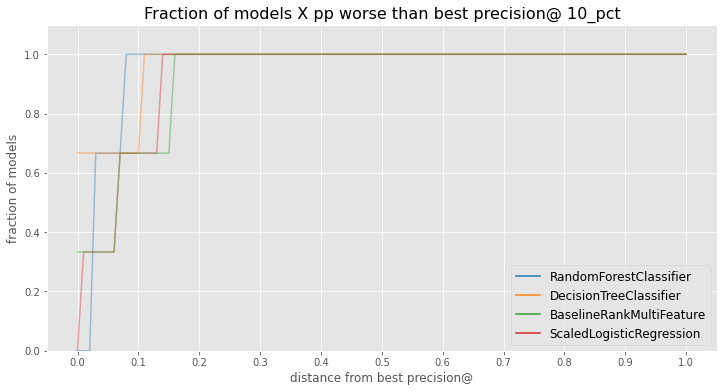

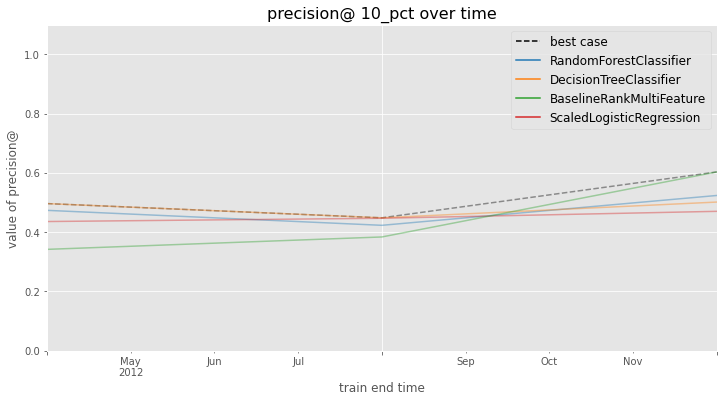

In [34]:
aud.plot_model_groups()

With our first default setting, we don't filter out models because `max_from_best=1.0` and `threshold_value=0.0` are the loosest criteria.

- The first graph shows us the fraction of models worse than the best model by distance with respect to the metric of interest.
- The second graph shows us the performance of a model group over time. The dashed line is the best case at that time period.

In [35]:
# model groups that conform to the current filters
aud.thresholded_model_group_ids

{1, 2, 3}

We won't delve further into the model selection process here, but see the resources noted above for a deeper look.

## Bias Audit

Finally, we turn to the results of the bias audit using the toolkit [aequitas](http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/), which can be found in the table `test_results.aequitas`:

In [43]:
pd.read_sql("""SELECT * FROM test_results.aequitas LIMIT 5""", conn)

,model_id,subset_hash,tie_breaker,evaluation_start_time,evaluation_end_time,matrix_uuid,parameter,attribute_name,attribute_value,total_entities,...,Impact_Parity,FDR_Parity,FPR_Parity,FOR_Parity,FNR_Parity,TypeI_Parity,TypeII_Parity,Equalized_Odds,Unsupervised_Fairness,Supervised_Fairness
0,1,,worst,2012-04-01,2012-06-30,9916387c3af41f79c711eca5b49e2e93,25_abs,teacher_prefix,Mr.,388,...,None,None,None,None,None,None,None,None,None,None
1,1,,worst,2012-04-01,2012-06-30,9916387c3af41f79c711eca5b49e2e93,25_abs,teacher_prefix,Mrs.,388,...,None,None,None,None,None,None,None,None,None,None
2,1,,worst,2012-04-01,2012-06-30,9916387c3af41f79c711eca5b49e2e93,25_abs,teacher_prefix,Ms.,388,...,None,None,None,None,None,None,None,None,None,None
3,1,,worst,2012-04-01,2012-06-30,9916387c3af41f79c711eca5b49e2e93,50_abs,teacher_prefix,Mr.,388,...,None,None,None,None,None,None,None,None,None,None
4,1,,worst,2012-04-01,2012-06-30,9916387c3af41f79c711eca5b49e2e93,50_abs,teacher_prefix,Mrs.,388,...,None,None,None,None,None,None,None,None,None,None


For each model, the table contains the full set of confusion matrix values for the thresholds and each attribute value specified in your `bias_audit_config`, as well as disparities relative to reference group identified in that configuration file. Note that these disparities are calculated as ratios with the reference group as the denominator.

Audition provides some tools for visualizing these results. If we assume the appropriate fairness metric for this context is true positive rate (TPR) disparity, let's take a look at how model 12 performed at the 10% threshold:

In [37]:
import triage.component.postmodeling.fairness.aequitas_utils as au
import aequitas.plot as ap

# Load Data
bdf = au.get_aequitas_results(conn, parameter = "0.1_pct", model_id = 12)

# attribute of interest
attribute = 'teacher_prefix'

# fairness metric we care about
metrics = ['tpr']

# tolerance for disparities
disparity_tolerance = 1.30

The `disparity` plot shows disparities for each group on the selected metric relative to the reference group:

In [38]:
ap.disparity(bdf, metrics, attribute, fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

The `absolute` plot will show the value of the true positive rate itself:

In [39]:
ap.absolute(bdf, metrics, attribute, fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

We might also want to look at the disparities across models and how they relate to our metric for evaluating model accuracy to consider trade-offs between these goals, which we can do by joining the aequitas table to the evaluations:

In [40]:
acc_metric = 'precision@'
disp_metric = 'tpr_disparity'
acc_thresh = '10_pct'
disp_thresh = '0.1_pct'
attribute_name = 'teacher_prefix'
attribute_value = 'Mrs.'

df = pd.read_sql(f"""
  WITH last_end_time AS (
    SELECT max(train_end_time) AS train_end_time
    FROM triage_metadata.models
  )
  , last_models AS (
    SELECT model_id
    FROM triage_metadata.models
    JOIN last_end_time USING(train_end_time)
  )
  , eval_metrics AS (
    SELECT e.model_id, e.stochastic_value
    FROM test_results.evaluations e
    JOIN last_models m USING(model_id)
    WHERE e.metric = '{acc_metric}' AND e.parameter = '{acc_thresh}'
  )
  , fair_metrics AS (
    SELECT a.model_id, a.{disp_metric}
    FROM test_results.aequitas a
    JOIN last_models m USING(model_id)
    WHERE a.parameter = '{disp_thresh}'
      AND a.attribute_name = '{attribute_name}'
      AND a.attribute_value = '{attribute_value}'
      AND tie_breaker = 'worst'
  )
  SELECT * 
  FROM eval_metrics e
  JOIN fair_metrics f USING(model_id)
  ORDER BY e.stochastic_value DESC
  """, conn)

df

,model_id,stochastic_value,tpr_disparity
0,9,0.6032,0.2242
1,12,0.5238,0.4484
2,7,0.5016,0.7585
3,8,0.4704,0.8427


<AxesSubplot:xlabel='stochastic_value', ylabel='tpr_disparity'>

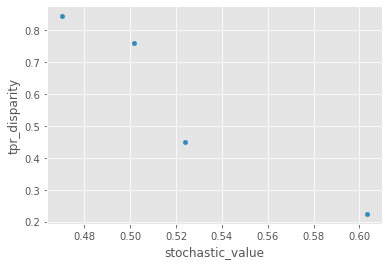

In [41]:
df.plot('stochastic_value', disp_metric, kind='scatter')

This final plot helps us visualize the fairness-accuracy trade-offs across the grid of models we ran, with the disparity metric on the y-axis (values closer to 1 don't favor either group) and the accuracy metric on the x-axis (higher values being more accurate).

Although you might choose a model from this set based on these trade-offs, you might also want to consider some of the many fairness-enhancing methods that have been developed for machine learning recently. For an introduction, you may want to explore the materials from our [hands-on fairness tutorial](https://dssg.github.io/fairness_tutorial/).

## Where Do I Go From Here?

You've reached the end of this online `triage` tutorial, but have a few potential options for where to go next:
- Feel free to tinker with the parameters, features, and outputs of the DonorsChoose example here for a working sandbox to start from (keeping in mind the resource constraints of colab, of course)
- For a more comprehensive tutorial that explores `triage` concepts and functionality in much more depth, see our [Dirty Duck Tutorial](https://dssg.github.io/triage/dirtyduck/)
- If you're ready to get started with using `triage` for your own project, check out our [Quickstart Guide](https://dssg.github.io/triage/quickstart/)